In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
#from wordcloud import WordCloud, STOPWORDS
import gzip
from pylab import xticks
import tqdm.notebook 
from tqdm.notebook import trange
import pickle
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime


In [2]:


#Importing character metadata
df_char_meta = pd.read_table("./data/MovieSummaries/character.metadata.tsv", header=None)
df_char_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "character name", "Actor date of birth", "Actor gender", 
            "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", 
            "Freebase character ID", "Freebase actor ID"]

#Importing the data
df_movie_meta = pd.read_table("./data/MovieSummaries/movie.metadata.tsv", header=None)
df_movie_meta.columns=["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", 
                     "Movie box office revenue", "Movie runtime", "Movie languages", "Movie countries", "Movie genres"]



#Creating lists in desired columns
df_movie_meta['Movie countries'] = df_movie_meta['Movie countries'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie countries'] = df_movie_meta['Movie countries'].apply(lambda x: list(x.values()))
df_movie_meta['Movie genres'] = df_movie_meta['Movie genres'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie genres'] = df_movie_meta['Movie genres'].apply(lambda x: list(x.values()))
df_movie_meta['Movie languages'] = df_movie_meta['Movie languages'].apply(lambda x: json.loads(x)) # Converts to dictionnary
df_movie_meta['Movie languages'] = df_movie_meta['Movie languages'].apply(lambda x: list(x.values()))

#Keeping only the year of the movie
df_movie_meta.query("`Movie release date` > '1915'", inplace = True)
df_movie_meta["Movie release date"] = pd.to_datetime(df_movie_meta["Movie release date"])
df_movie_meta["Movie release date"] = df_movie_meta["Movie release date"].dt.year



df_merged_meta = pd.DataFrame(df_char_meta[["Freebase movie ID", "Actor gender", "Actor age at movie release"]])
df_merged_meta = pd.merge(df_merged_meta, df_movie_meta[["Freebase movie ID", "Movie release date", 
                                                        "Movie countries", "Movie genres"]], on="Freebase movie ID")


print("Size of the gloabal dataset: " + str(df_merged_meta.shape[0]))
df_merged_meta.dropna(subset=['Actor gender'], inplace = True)
print("Size after removing entries with no gender: " + str(df_merged_meta.shape[0]))
df_merged_meta.dropna(subset=['Actor age at movie release'], inplace = True)
print("Size after removing entries with no age at movie release: " + str(df_merged_meta.shape[0]))


Size of the gloabal dataset: 437830
Size after removing entries with no gender: 392446
Size after removing entries with no age at movie release: 290726


# Question 1

In [29]:
world = df_merged_meta.copy()

## Clean the dataset

### Only keep :
    - Films released between 1940 and 2010
    - Raw with a positive actor age

In [30]:
init_len = world.shape[0]
world.query('`Movie release date` >= 1940 and `Movie release date` <= 2010 ', inplace=True)
world.query('`Actor age at movie release` > 0', inplace=True)
perc = world.shape[0]/init_len *100
print("%.2f" % perc, '% of entries are exploitable (',world.shape[0],'entries )')

#Change format :
world['Movie countries'] = world['Movie countries'].astype('str')
world['Movie genres'] = world['Movie genres'].astype('str')

91.41 % of entries are exploitable ( 265763 entries )


## Split the dataset into three major regions : 
    - Usa   : Hollywood
    - India : Bollywood
    - West Europe

In [31]:
#Split it into three regions
usa_df = world[world['Movie countries'].str.contains('United State')]
print('usa entries :',usa_df.shape[0])
india_df = world[world['Movie countries'].str.contains('India')]
print('india entries :',india_df.shape[0])
west_europe = ['France','Italy','German','Spain','Luxembourg','Netherlands','United kingdom'] 
west_europe_df = world[world['Movie countries'].str.contains('|'.join(west_europe),case=False)]
print('west europe entries :',west_europe_df.shape[0])

usa entries : 151118
india entries : 30296
west europe entries : 62456


## Bootsrap function

In [32]:
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

## Evolution of the actor/actress age

In [33]:
#Usa
usa_men = usa_df.query('`Actor gender` == "M"')
usa_women = usa_df.query('`Actor gender` == "F"')
stats_by_year_usa_men = usa_men.groupby(usa_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_usa_women = usa_women.groupby(usa_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

#India
india_men = india_df.query('`Actor gender` == "M"')
india_women = india_df.query('`Actor gender` == "F"')
stats_by_year_india_men = india_men.groupby(india_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_india_women = india_women.groupby(india_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

#Europe
europe_men = west_europe_df.query('`Actor gender` == "M"')
europe_women = west_europe_df.query('`Actor gender` == "F"')
stats_by_year_europe_men = europe_men.groupby(europe_men['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))
stats_by_year_europe_women = europe_women.groupby(europe_women['Movie release date']).apply(lambda x: pd.Series({
        'average_age': x['Actor age at movie release'].mean(),
        'lower_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[0],
        'upper_err_age': bootstrap_CI(x['Actor age at movie release'], 1000)[1]
    }))

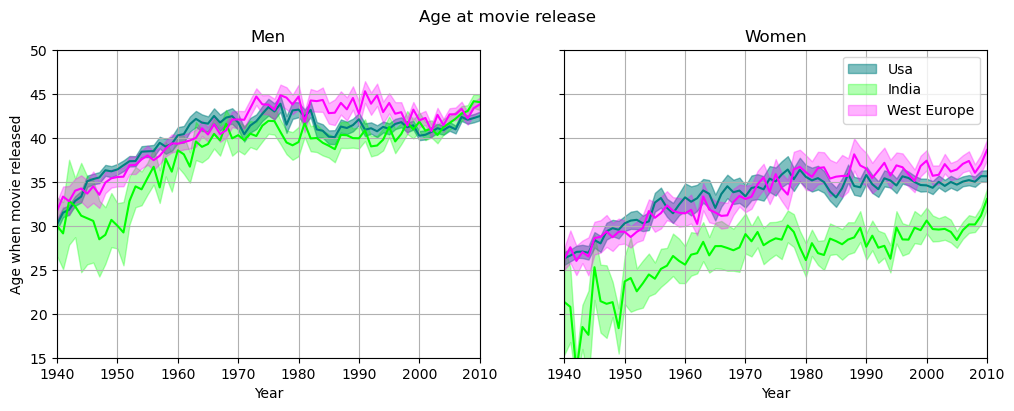

In [34]:
#Plot :
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, sharex=True, figsize=(12, 4))
fig.suptitle('Age at movie release')
fig.subplots_adjust(hspace=.1)
ax1.set_xlim([1940,2010])
ax1.set_ylim([15,50])
ax1.grid(True)
ax2.grid(True)
ax1.set_title('Men')
ax2.set_title('Women')
ax1.set_xlabel('Year')
ax1.set_ylabel('Age when movie released')
ax2.set_xlabel('Year')


#USA :

ax1.fill_between(stats_by_year_usa_men.index, stats_by_year_usa_men.lower_err_age,
                 stats_by_year_usa_men.upper_err_age, alpha = 0.5, color = 'teal')
ax1.plot(stats_by_year_usa_men.average_age, color = 'teal')

ax2.fill_between(stats_by_year_usa_women.index, stats_by_year_usa_women.lower_err_age,
                 stats_by_year_usa_women.upper_err_age, alpha = 0.5, color = 'teal', label='Usa')
ax2.plot(stats_by_year_usa_women.average_age, color = 'teal')



#INDIA :

ax1.fill_between(stats_by_year_india_men.index, stats_by_year_india_men.lower_err_age,
                 stats_by_year_india_men.upper_err_age, alpha = 0.3, color = 'lime', label='India')
ax1.plot(stats_by_year_india_men.average_age, color = 'lime')

ax2.fill_between(stats_by_year_india_women.index, stats_by_year_india_women.lower_err_age,
                 stats_by_year_india_women.upper_err_age, alpha = 0.3, color = 'lime', label='India')
ax2.plot(stats_by_year_india_women.average_age, color = 'lime', )


#EUROPE :

ax1.fill_between(stats_by_year_europe_men.index, stats_by_year_europe_men.lower_err_age,
               stats_by_year_europe_men.upper_err_age, alpha = 0.3, color = 'magenta')
ax1.plot(stats_by_year_europe_men.average_age, color = 'magenta')

ax2.fill_between(stats_by_year_europe_women.index, stats_by_year_europe_women.lower_err_age,
                 stats_by_year_europe_women.upper_err_age, alpha = 0.3, color = 'magenta', label='West Europe')
ax2.plot(stats_by_year_europe_women.average_age, color = 'magenta')

plt.legend()

We can see that men's age follow the same trend with no bias for the three differents regions. However concerning women's ages, India has a bias from the two other areas.